# NLP exploration on plot summaries
This notebook implements Natural Language Processing (NLP) on the plots summaries of the CMU Movie Summary Corpus.

In [1]:
# Import the needed libarairies
import re # to use regex pattern to display only some lines of the plot summaries
import time # to monitor how long the NLP runs lasts
import pickle # in order to open the lexicon of american words
import warnings # to ignore pandas version warning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter # to count tokens in each plot summaries
from geopy.geocoders import Nominatim # to only keep the GPE with the highest probabability, i.e London UK and not London Ohio, US
from geopy.exc import GeocoderRateLimited # to handle timeout errors while doing too many request on the geopy server
from concurrent.futures import ThreadPoolExecutor # to parallelize the use of the geopy
from tqdm import tqdm # to print a progress bar to know where the processing is

import torch # for fatser NLP processing
import spacy # for NLP analysis
from spacy.matcher import PhraseMatcher # to implement Multi-word matching

# from itertools import zip_longest # to iterate over many lists at the same time

### CUDA verification in order to use laptop GPU. 
The used laptop for this analysis has the following graphic card: **Nvidia GeForce RTX 3050 Ti Laptop GPU**

In [2]:
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Current CUDA device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch CUDA available: True
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


### Opening the cleaned dataframes created for P2 and P3

In [3]:
########################### Read datasets from repository's data folder ############################
movie_mtd = pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
plot_summaries_df = pd.read_csv('data/plot_summaries_CMU.csv', sep = ',', usecols= ['ID', 'Summary'])

In [4]:
# Set a global background theme for all our plots and ignore warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

### Subdataset creation to faciliates the analysis

In [5]:
# Creating deep copies of original data frame to avoid messing it up
all_movies = movie_mtd.copy() # all movies in the dataset, no matter their production country
us_movies = movie_mtd.copy() 
us_partially_movies = movie_mtd.copy()
all_us_movies = movie_mtd.copy()
rest_world_non_US = movie_mtd.copy()

## Filtering the newly created dataframes for the analysis of nox office revenue, IMDb ratings and runtimes
# Movies strictly produced in the US
us_movies = us_movies[us_movies['countries'] == 'United States of America']
# Movies partially produced in the US
us_partially_movies = us_partially_movies[(us_partially_movies['countries'].str.contains('United States of America') == True) & (us_partially_movies['countries'] != 'United States of America')]
# Contains the movies strictly produced in the US and the ones partially produced in the US
all_us_movies = all_us_movies[(all_us_movies['countries'] == 'United States of America') | (all_us_movies['countries'].str.contains('United States of America') == True)]

# Non-US movies
rest_world_non_US = rest_world_non_US[(rest_world_non_US['countries'].str.contains('United States of America') == False) & (rest_world_non_US['countries'] != 'United States of America')]

In [6]:
us_movies.head()

,wiki_movie_ID,freebase_movie_ID,title,release_date,box_office,runtime,languages,countries,genres_CMU,release_year,genres_IMDB,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0,"Action,Horror,Sci-Fi",4.9,58894.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenet Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0,NaN,NaN,NaN
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"Silent film, English Language",United States of America,"Short Film, Silent film, Indie, Black-and-whit...",1913.0,"Comedy,Short",7.2,19.0
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,English Language,United States of America,"Musical, Comedy, Black-and-white",1938.0,"Drama,Music,Musical",6.8,2357.0
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,English Language,United States of America,"Drama, Black-and-white",1930.0,"Drama,Romance",5.4,356.0


### Opening of the Plot summaries dataset

In [7]:
# Increase the display width to see more characters per column
pd.set_option('display.max_colwidth', None)  # This removes the column width limit

plot_summaries_df['Plot Summary Preview'] = plot_summaries_df['Summary'].apply(
    lambda x: ' '.join(re.split(r'(?<=[.!?])\s+', x)[:4]) # the re pattern checks if the sentnec ends with ".!?" and the '.join' rebuilds the string after the split
)

# Sort the plot summaries according to the Wikipedia movie ID
plot_summaries_df_sorted = plot_summaries_df.sort_values(ascending = True , by= 'ID')

print(f"The size of the plot summaries dataset is {plot_summaries_df.shape}.")

# Show the first 4 sentences in the Preview column
plot_summaries_df[['ID', 'Plot Summary Preview']].head()

The size of the plot summaries dataset is (42303, 3).


,ID,Plot Summary Preview
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had earlier given jail sentence to Manapally in a corruption case. Induchoodan, who had achieved top rank in Indian Civil Service loses the post and Manapally Sudheeran ([[Saikumar enters the list of civil service trainees. We learn in flashback that it was Ramakrishnan the son of Moopil Nair , who had actually killed his classmate."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfortunately for the Kid, the woman ""belongs"" to notorious gangster Moose Moran , as does the money."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy returns to the tent to check on Azaria and is certain she sees a dingo with something in its mouth running off as she approaches. When she discovers the infant is missing, everyone joins forces to search for her, without success."


### Merging the plot summaries dataset with the movie_mtd dataset in order to distinguish between US-only, partially US and non US produced (= RoW) movies

In [8]:
# Performing inner joins to be sure each movie kept after the merge has a plot summaries and filtering to keep only useful columnbs for the rest of the analysis
# ID column is not useful anymore so one can remove it
plot_summaries_all_movies = pd.merge(plot_summaries_df, all_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title', 'Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_us_movies = pd.merge(plot_summaries_df, us_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title','Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_us_partially_movies = pd.merge(plot_summaries_df, us_partially_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title', 'Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_RoW_movies = pd.merge(plot_summaries_df, rest_world_non_US, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title','Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

print(f"The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is {plot_summaries_all_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is {plot_summaries_us_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is {plot_summaries_us_partially_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is {plot_summaries_RoW_movies.shape}.")

The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is (42208, 7).
The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is (17776, 7).
The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is (3015, 7).
The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is (18105, 7).


One notices here that the total number of plot summaries has slightly decreased after the merge with the dataset containing movies metadata (from 42'303 plot summaries to 42'208). This is likely due to the fact that the inner join performed has discarded 95 plots where no movie metadata were available.

### Basics stats on the plot summaries

In [ ]:
# # Calculate the mean number of words per summary
# mean_number_words_per_summary = plot_summaries_df['word_count'].mean()

# # Count the number of words in each summary using len(x.split()) directly
# plot_summaries_df['word_count'] = plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) # count words in a string by splitting on spaces 8by default)

# number_summaries_more_500_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) >= 500]['Summary'].count()
# number_summaries_more_1000_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) >= 1000]['Summary'].count()
# number_summaries_more_3000_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) > 3000]['Summary'].count()


# print(f"Mean number of words per summary: {mean_number_words_per_summary:.2f}")

# print(f"The number of plot summaries with more than 500 words is {number_summaries_more_500_words}.")
# print(f"The number of plot summaries with more than 1000 words is {number_summaries_more_1000_words}.")
# print(f"The number of plot summaries with more than 3000 words is {number_summaries_more_3000_words}.")

# Whole dataset
basic_stats_numwords_plotsSummaries_all_movies = plot_summaries_all_movies['Summary'].apply(lambda x: len(str(x).split()))


# df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median (millions USD)', 'mean (millions USD)', 'std (millions USD)', 'max (millions USD)', 'min (millions USD)'])/1e6
# # To display only 2 decimals after the comma taking advantage of the Jupyter notebook environment
# df_basic_stat_box_office.style.format("{:.2f}") 
# Apply the `nlp` function to each summary
plot_summaries_all_movies['Processed_Summary'] = plot_summaries_all_movies['Summary'].apply(lambda x: nlp(x))

# Extract tokens from the processed summaries (if needed)
plot_summaries_all_movies['Tokens'] = plot_summaries_all_movies['Processed_Summary'].apply(lambda doc: [token.text for token in doc])

# Example: Access the tokens from a single summary
print(plot_summaries_all_movies['Tokens'].iloc[0])
plot_summaries_all_movies.head()

from collections import Counter
# # with stopwords and ponctuation
# words = [token.text for token in doc]
word_freq = Counter(plot_summaries_all_movies['Tokens'])
common_words = word_freq.most_common() # five most common tokens
# # without stopwords and ponctuation
# words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
# word_freq = Counter(words)
# common_words = word_freq.most_common()

In [8]:
def plot_counter(df, lower_bound=1, upper_bound=20): # setting default lower and upper bounds value
    """
    Function that counts the number of plot summaries containing a given number of words.

    Params:
        df (pd.DataFrame): DataFrame containing a column 'Summary'.
        lower_bound (int, optional): Minimum number of words in a plot summary (exclusive).
                                     Use None to apply no lower bound. Default is 1.
        upper_bound (int, optional): Maximum number of words in a plot summary (inclusive).
                                     Default is 20.
    Returns: The count of summaries within the specified word count range (int).
    """
    if 'Summary' not in df.columns:
        raise ValueError("The dataframe must have a column named 'Summary'.")

    # Compute plots counts once for efficiency
    plots_counts = df['Summary'].apply(lambda x: len(str(x).split())) # split words based on white spaces

    if lower_bound is None:
        # Apply only the upper bound
        return plots_counts[plots_counts >= upper_bound].count()
    else:
        # Apply both lower and upper bounds
        return plots_counts[(plots_counts > lower_bound) & (plots_counts <= upper_bound)].count()

# Initializing the need lists and dictionnary
list_name_df = ['All movies', 'US-only produced movies', 'Partially US-produced movies', 'Non US-produced movies']
list_df_plot_summaries = [plot_summaries_all_movies, plot_summaries_us_movies, plot_summaries_us_partially_movies, plot_summaries_RoW_movies]
list_set_number_words = [[1, 20], [20, 100], [100, 300], [300,500], [500, 1000], [1000, 2000], [2000, 3000]] # ranges of numbers of words in order to count the number of plots summaries falling in that range
dict_plot_count = {'All movies': [], 'US-only produced movies': [], 
                   'Partially US-produced movies': [], 'Non US-produced movies': [], 
                   }

# Use of "zip" will make the loop terminates when the shortest iterable is exhausted so one put it in the second for loop to make sure all the 7 words count interval are processed
dict_plot_count = {name: [] for name in list_name_df}
interval_names = [f"{low}-{high}" for low, high in list_set_number_words]

for interval in list_set_number_words:
    for df, dico_name in zip(list_df_plot_summaries, list_name_df):
        word_count = plot_counter(df, lower_bound = interval[0], upper_bound = interval[1])
        dict_plot_count[dico_name].append(word_count)

# Create DataFrame with interval names as index and title
df_count_plot_summaries = pd.DataFrame(dict_plot_count, index=interval_names)

# Add a title for the rows as an index
df_count_plot_summaries.index.name = "Word number Interval"

# Compute the total number of plot summaries for each columns and add it as the last row of the df
df_count_plot_summaries.loc["Total"] = df_count_plot_summaries.sum(axis=0)

print("The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)")
df_count_plot_summaries.head(8)


The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)


,All movies,US-only produced movies,Partially US-produced movies,Non US-produced movies
Word number Interval,,,,
1-20,397,133,11,180
20-100,12137,4639,531,5662
100-300,14406,5600,702,6905
300-500,5933,2745,450,2392
500-1000,7867,3973,1073,2501
1000-2000,1381,658,235,428
2000-3000,69,25,10,29
Total,42190,17773,3012,18097


One notices first that most of the plot summaries show a number of words between 100 and 300. Next, come the plots having 20-100 words intheir summaries. One sees that they are very few plots summaries with more than 2000 words. Finally, one sees that with those word intervals one captures nearly all the movies. Indeed, th column *total* for all the movies shows 42190 movies out of 42208 (see above cell) meaning that only 18 plots summarie shave more than 3000 words. One observe similar behavior for the US-only produced, Partially US-produced and Non Us-produced movies.

Visualization

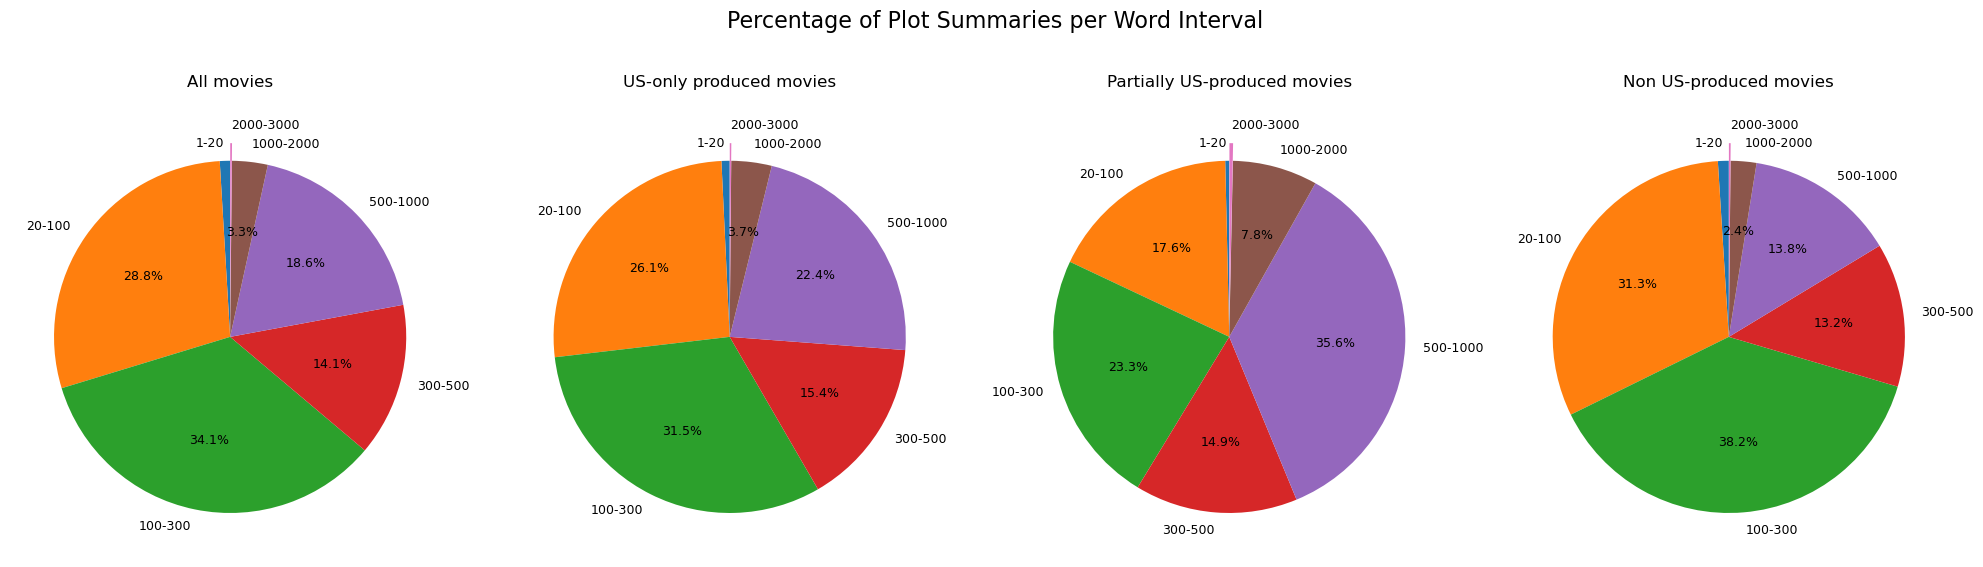

In [9]:
colors = sns.color_palette("pastel", len(df_count_plot_summaries.index))

def autopct_threshold(pct):
    return f'{pct:.1f}%' if pct > 1 else ''  # Only display if percentage > 1%

plots = df_count_plot_summaries.iloc[:-1].plot.pie(
    subplots=True,
    figsize=(20, 8),
    title= False,
    legend=False,
    autopct=autopct_threshold,
    explode=(0, 0, 0, 0, 0, 0, 0.1),
    shadow=False,
    startangle=90,
    textprops={'fontsize': 9},
    color = colors
)

# Manually set the titles above the charts
titles = df_count_plot_summaries.columns
for ax, title in zip(plots, titles):
    ax.set_title(title, fontsize=12, y=1.05)  # Adjust y to move title above
    ax.set_ylabel('')  # Remove the default title on the left

# Global adjustments
plt.suptitle("Percentage of Plot Summaries per Word Interval", fontsize=16)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()

# NLP on plot summaries

N.B: **For all the analysis below**, one processes **only the 3 following dataset: plot_summaries_us_movies, plot_summaries_us_partially_movies, plot_summaries_RoW_movies** due to the very lomg running time. The complete plot summaries dataset from the CMU Corpus is not processed. It is not a problem for the purpose of the analysis since one seeks to study the movies depending on if they were produced in the US, partially in the US or completely abroad.

## Assessing the american culture in plots summaries using GPE (i.e. location only)
One recalls that GPE stands for *Geopolitical entity, i.e. countries, cities, states* ([see here](https://spacy.io/usage/linguistic-features/)). The aim is here to assess the "percentage" of amercian culture in each plot summaries by only looking at the locations present in the plot. Indeed, if the plot summary, i.e. the summary of the story told by the movie, contains some amercian cities or states name(s), it "represents" in a way the amercian culture since the movie director chose the US as a location to tell his story (or part of his story in other locations are present).

For this first part, one does not use a set containing all cities, counties and states in the US but rather the python library *GeoPy* that allows to return the most probable location among all possible ones worldwide ([Geopy nominatim](https://geopy.readthedocs.io/en/stable/#nominatim)). For example, the city of *London* exists both in the UK and in the US, in Ohio ([London Ohio US](https://en.wikipedia.org/wiki/London,_Ohio)). The only downside of this approach comes from the requests the code must perfomr to the *Geopy* API. This slows down the computations a bit since one must pause the program to avoid the server to block the request. To partially solve this issue, one implements caching: a caching dictionary stores every scanned locations by the *Nominatim* function to avoid requesting the same locations many time during the processing.

Although this approach is slower than just reading a CSV file containing all US cities, counties and states and creating a Python set, it has the big advantage of not counting famous cities as London or Edinburgh as being part of the US. Indeed, many US cities are named from famous cities worldwide. For example the city of Edinburgh located in Scotland, also exists in the US ([Edinburgh, Indiana US](https://en.wikipedia.org/wiki/Edinburgh,_Indiana )). To conclude the use of the *Geopy* library and API allows to obtain robust results to assess the precentage of american culture by looking only at locations in the plot summaries.

#### 1) Processing the partially US-produced movies
Each of the 3 "sub"-dataframes are processed separately due to the consequent running time due to the use of the `en_core_web_trf` spacy NLP model (see below).

Functions used to extract the US GPE freqeuncies and retrieve the american culture "percentage" based on locations only

In [11]:
# Acknowledement: ChatGPT was used here in order to better understand how to work with CUDA and with the NLP pipeline (https://chatgpt.com/)

# Initialize caching dictionary to avoid requesting the same locations many times
geocode_cache = {}

# Geocode a single location and check if it's in the US
def geocode_location(location):
    geolocator = Nominatim(user_agent="location_disambiguator", timeout=10)
    locate = geolocator.geocode(location)
    check = True if locate and 'United States' in str(locate) else False
    return location, check

# Cached geocoding function tio avoid looking sevarl time for the same location of the geopy API
def geocode_location_cached(location):
    if location not in geocode_cache:
        for attempt in range(3):  # Retry up to 3 times
            try:
                time.sleep(1)  # Respect API rate limits
                geocode_cache[location] = geocode_location(location)
                break
            except GeocoderRateLimited:
                print(f"Rate-limited for location: {location}. Retrying...")
                time.sleep(10)  # Wait before retrying
    return geocode_cache[location]

# Geocode multiple locations in parallel
def geocode_locations_parallel(locations):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(geocode_location_cached, locations))
    return results

# Extract GPE entities and compute US frequencies with geocoding
def extract_GPE_and_compute_US_frequencies_batch(summaries):
    results = []
    for doc in tqdm(nlp.pipe(summaries, batch_size=500), total=len(summaries), desc="Processing Summaries"):
        GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
        GPE_frequencies_all = Counter(GPE_entities)
        geocoded_results = geocode_locations_parallel(GPE_entities)
        GPE_US_frequencies = Counter(location for location, is_in_us in geocoded_results if is_in_us)
        Percentage_US_culture = (
            sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values())
            if sum(GPE_frequencies_all.values()) > 0 else 0
        )
        results.append((GPE_entities, GPE_US_frequencies, Percentage_US_culture))
    return results

**Disclaimer**: one must keep in mind that **the three below cells run** in about $\color{red}{\text{1 hour and 11 minutes, 4 hours and 10 minutes, 4 hours 20 minutes}}$ with the **Nvidia GeForce RTX 3050 Ti Laptop GPU** used here.

In [10]:
# Acknowledement: ChatGPT was used here in order to better understand how to work with CUDA and with the NLP pipeline (https://chatgpt.com/)

if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu()  # Enable GPU use for SpaCy
    nlp = spacy.load("en_core_web_trf")  # Use a more complex model leveraging transformers (cf. https://spacy.io/models/en/)
    print("Using Spacy English transformer pipeline.")
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")
    print("Using Spacy English pipeline optimized for CPU.")

# Copying the original datframe to avoid messing it up
df_plots_us_partially_movies_GPE = plot_summaries_us_partially_movies.copy()

start_time = time.time()
print("Processing starting.")

# Call batch processing function with GPU
extracted_results = extract_GPE_and_compute_US_frequencies_batch(df_plots_us_partially_movies_GPE['Summary'].tolist())
df_plots_us_partially_movies_GPE['GPE_entities'] = [res[0] for res in extracted_results]
df_plots_us_partially_movies_GPE['GPE_US_frequencies'] = [res[1] for res in extracted_results]
df_plots_us_partially_movies_GPE['Percentage_american_culture'] = [res[2] for res in extracted_results]

# Drop summaries and save results to .csv file
df_plots_us_partially_movies_GPE = df_plots_us_partially_movies_GPE.drop(columns=['Summary'])
df_plots_us_partially_movies_GPE.to_csv("data/NLP_datasets/us_partially_movies_NLP_GPE.csv", sep=',', encoding='utf-8', index=False, header=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

CUDA is available. Using GPU.
Using Spacy English transformer pipeline.
Processing starting.


Processing Summaries:   1%|          | 20/3015 [04:58<1:36:08,  1.93s/it]  

Rate-limited for location: Paris. Retrying...Rate-limited for location: Munich. Retrying...

Rate-limited for location: Israel. Retrying...
Rate-limited for location: Beirut. Retrying...


Processing Summaries:   2%|▏         | 55/3015 [06:23<2:19:12,  2.82s/it]

Rate-limited for location: Riyadh. Retrying...


Processing Summaries:   2%|▏         | 64/3015 [06:44<1:19:01,  1.61s/it]

Rate-limited for location: Khartoum. Retrying...


Processing Summaries:  16%|█▌        | 473/3015 [14:55<34:38,  1.22it/s]  

Rate-limited for location: Quintessa. Retrying...


Processing Summaries:  53%|█████▎    | 1603/3015 [45:40<22:03,  1.07it/s]   

Rate-limited for location: Nijmegen. Retrying...
Rate-limited for location: Arnhem. Retrying...
Rate-limited for location: Arnhem. Retrying...
Rate-limited for location: Arnhem. Retrying...


Processing Summaries:  67%|██████▋   | 2010/3015 [55:08<3:30:15, 12.55s/it]

Rate-limited for location: Thornfield. Retrying...


Processing Summaries:  69%|██████▉   | 2075/3015 [56:00<05:46,  2.71it/s]  

Rate-limited for location: Zangaro. Retrying...
Rate-limited for location: Zangaro. Retrying...


Processing Summaries:  70%|███████   | 2112/3015 [56:28<07:18,  2.06it/s]

Rate-limited for location: Wuzzlewood. Retrying...
Rate-limited for location: Wuzzlewood. Retrying...
Rate-limited for location: Wuzzlewood. Retrying...


Processing Summaries:  85%|████████▌ | 2573/3015 [1:06:23<03:43,  1.98it/s]  

Rate-limited for location: Addisford. Retrying...Rate-limited for location: Selmouth. Retrying...



Processing Summaries:  94%|█████████▍| 2829/3015 [1:08:53<00:33,  5.62it/s]

Rate-limited for location: Avalon. Retrying...
Rate-limited for location: Orkney. Retrying...
Rate-limited for location: Beltane. Retrying...
Rate-limited for location: Orkney. Retrying...


Processing Summaries: 100%|██████████| 3015/3015 [1:11:33<00:00,  1.42s/it]

Execution time: 71.56 minutes. NLP processing done.


Quick visualization of the results

In [15]:
df_GPE_partially_us = pd.read_csv("data/NLP_datasets/us_partially_movies_NLP_GPE.csv", sep=',')


mean_american_culture_GPE_partially_us_movies = df_GPE_partially_us['Percentage_american_culture'].mean()*100

# count the proportions of zeros
df_GPE_partially_us['Percentage_american_culture'] = pd.to_numeric(df_GPE_partially_us['Percentage_american_culture']).astype('float64')
proportion_0_percenatge_us_partially = (len(df_GPE_partially_us[df_GPE_partially_us['Percentage_american_culture'] == 0.0])/len(df_GPE_partially_us))*100

print(f"The mean american culture percentage for partially US-produced movies using only GPE information is {mean_american_culture_GPE_partially_us_movies:.2f} %.")
print(f"The percentage of zero values on the partially US GPE dataset is: {proportion_0_percenatge_us_partially:.2f} %.")
print(f"Shape verification of the US-only GPE dataset: shape: {df_GPE_partially_us .shape}")

df_GPE_partially_us.head(10)
# https://en.wikipedia.org/wiki/London,_Ohio
# https://en.wikipedia.org/wiki/Edinburgh,_Indiana 

The mean american culture percentage for partially US-produced movies using only GPE information is 27.61 %.
The percentage of zero values on the partially US GPE dataset is: 60.17 %.
Shape verification of the US-only GPE dataset: shape: (3015, 9)


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
0,A Cry in the Dark,6908797.0,NaN,1988.0,NaN,NaN,"['Azaria', 'Uluru']",Counter(),0.00
1,End Game,NaN,"Action,Thriller",2006.0,5.1,5745.0,[],Counter(),0.00
2,"Come Back, Africa",NaN,NaN,1960.0,NaN,NaN,"['Johannesburg', 'Sophiatown']",Counter(),0.00
3,Kehtaa Hai Dil Baar Baar,NaN,"Comedy,Drama,Romance",2002.0,4.7,204.0,"['India', 'New York']",Counter({'New York': 1}),0.50
4,Pieces,2032311.0,NaN,1982.0,NaN,NaN,['Boston'],Counter({'Boston': 1}),1.00
5,The Good Life,NaN,"Comedy,Drama",2007.0,6.4,2352.0,['Nebraska'],Counter({'Nebraska': 1}),1.00
6,Eastern Promises,17266000.0,NaN,2007.0,NaN,NaN,"['London', 'UK', 'London', 'Edinburgh']",Counter(),0.00
7,"Wait Until Spring, Bandini",NaN,Drama,1989.0,6.2,754.0,['Colorado'],Counter({'Colorado': 1}),1.00
8,Sophie's Choice,30036000.0,"Drama,Romance",1982.0,7.5,53987.0,"['Brooklyn', 'U.S.', 'Brooklyn', 'Virginia']","Counter({'Brooklyn': 2, 'Virginia': 1})",0.75
9,Until Death,NaN,"Action,Crime,Drama",2007.0,5.7,10503.0,"['New Orleans', 'New Orleans']",Counter({'New Orleans': 2}),1.00


First one notices that the *Geopy* library gives some robust results. Indeed, one immediately sees that London and Edinburgh are not counted as US locations because the probability is much higher that the plot summary talks about London UK than about London, Ohio, US. Moreover, for the movie *Come Back, Africa* that takes place in South Africa (**citer**), one notices that the city of Johannesburg is not treated as being part of the State of **citer** which is the desired output. The US states such as Nebraska and Colorado are also perfectly recognised. One analyses the percentage of American culture in the plot, 5 cells below.

#### 2) Processing the US-only produced movies

In [12]:
# Acknowledement: ChatGPT was used here in order to better understand how to work with CUDA and with the NLP pipeline (https://chatgpt.com/)

if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu()  # Enable GPU use for SpaCy
    nlp = spacy.load("en_core_web_trf")  # Use a more complex model leveraging transformers (cf. https://spacy.io/models/en/)
    print("Using Spacy English transformer pipeline.")
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")
    print("Using Spacy English pipeline optimized for CPU.")

# Copying the original datframe to avoid messing it up
df_plots_us_only_movies_GPE = plot_summaries_us_movies.copy()

start_time = time.time()
print("Processing starting.")

# Call batch processing function with GPU
extracted_results = extract_GPE_and_compute_US_frequencies_batch(df_plots_us_only_movies_GPE['Summary'].tolist())
df_plots_us_only_movies_GPE['GPE_entities'] = [res[0] for res in extracted_results]
df_plots_us_only_movies_GPE['GPE_US_frequencies'] = [res[1] for res in extracted_results]
df_plots_us_only_movies_GPE['Percentage_american_culture'] = [res[2] for res in extracted_results]

# Drop summaries and save results
df_plots_us_only_movies_GPE = df_plots_us_only_movies_GPE.drop(columns=['Summary'])
# filtered_df.drop(columns=['Summary'], inplace=True)
df_plots_us_only_movies_GPE.to_csv("data/NLP_datasets/us_only_movies_NLP_GPE.csv", sep=',', encoding='utf-8', index=False, header=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

df_plots_us_only_movies_GPE.head()

CUDA is available. Using GPU.
Using Spacy English transformer pipeline.
Processing starting.


Processing Summaries:   0%|          | 6/17776 [03:53<72:10:39, 14.62s/it]   

Rate-limited for location: Cyprus. Retrying...Rate-limited for location: Gan Dafna. Retrying...



Processing Summaries:   1%|          | 140/17776 [06:02<7:07:18,  1.45s/it]

Rate-limited for location: Corinth. Retrying...
Rate-limited for location: Antioch. Retrying...


Processing Summaries:   5%|▌         | 909/17776 [17:59<2:53:37,  1.62it/s]  

Rate-limited for location: Kotor. Retrying...
Rate-limited for location: Montenegro. Retrying...


Processing Summaries:   5%|▌         | 961/17776 [18:33<1:33:06,  3.01it/s]

Rate-limited for location: Panama. Retrying...
Rate-limited for location: Binghampton. Retrying...


Processing Summaries:   6%|▌         | 1053/17776 [23:19<3:29:53,  1.33it/s]  

Rate-limited for location: Little Rock's. Retrying...
Rate-limited for location: Columbus. Retrying...
Rate-limited for location: Columbus. Retrying...
Rate-limited for location: Wichita. Retrying...


Processing Summaries:  11%|█         | 1933/17776 [34:21<1:07:30,  3.91it/s] 

Rate-limited for location: Santa Ana. Retrying...


Processing Summaries:  23%|██▎       | 4047/17776 [1:11:41<5:17:47,  1.39s/it]  

Rate-limited for location: Guinea-Bissau. Retrying...Rate-limited for location: the Republic of the Marshall Islands. Retrying...



Processing Summaries:  31%|███▏      | 5586/17776 [1:34:01<1:32:16,  2.20it/s] 

Rate-limited for location: West Chester. Retrying...
Rate-limited for location: Finland. Retrying...


Processing Summaries:  32%|███▏      | 5770/17776 [1:35:31<2:06:33,  1.58it/s]

Rate-limited for location: Valdez. Retrying...
Rate-limited for location: Whitehorse. Retrying...
Rate-limited for location: Valdez. Retrying...


Processing Summaries:  35%|███▌      | 6235/17776 [1:42:32<54:35,  3.52it/s]   

Rate-limited for location: Ambleve. Retrying...
Rate-limited for location: Ambleve. Retrying...
Rate-limited for location: Ambleve. Retrying...
Rate-limited for location: Ambleve. Retrying...


Processing Summaries:  37%|███▋      | 6533/17776 [1:48:39<7:16:37,  2.33s/it] 

Rate-limited for location: Eatonville. Retrying...


Processing Summaries:  39%|███▉      | 6922/17776 [1:51:19<2:04:15,  1.46it/s]

Rate-limited for location: Moria. Retrying...
Rate-limited for location: Rivendell. Retrying...
Rate-limited for location: Gondor. Retrying...
Rate-limited for location: Lothlórien. Retrying...


Processing Summaries:  42%|████▏     | 7388/17776 [1:57:57<21:08,  8.19it/s]   

Rate-limited for location: Halloweentown. Retrying...


Processing Summaries:  51%|█████     | 9038/17776 [2:23:08<3:46:01,  1.55s/it] 

Rate-limited for location: Krynn. Retrying...


Processing Summaries:  61%|██████    | 10812/17776 [2:44:53<34:02,  3.41it/s]   

Rate-limited for location: Bluesville. Retrying...
Rate-limited for location: Joyville. Retrying...
Rate-limited for location: Bluesville. Retrying...
Rate-limited for location: Bluesville. Retrying...


Processing Summaries:  96%|█████████▌| 16995/17776 [4:01:41<04:43,  2.75it/s]   

Rate-limited for location: Denton. Retrying...
Rate-limited for location: Denton. Retrying...


Processing Summaries:  98%|█████████▊| 17462/17776 [4:07:00<01:07,  4.67it/s]  

Rate-limited for location: Ta-Koro. Retrying...Rate-limited for location: Ko-Koro. Retrying...



Processing Summaries: 100%|██████████| 17776/17776 [4:10:37<00:00,  1.18it/s]


Execution time: 250.64 minutes. NLP processing done.


NameError: name 'df_plots_us_partially_movies_GPE' is not defined

**Disclaimer**: please ignore the *NameError* at the end of this cell. It was a small mistake one forgot to remove before running the cell. One leaves the cell like that due to its very long running time.

Quick visualization of the results

In [16]:
# Visualization of the result:
df_GPE_us_only = pd.read_csv("data/NLP_datasets/us_only_movies_NLP_GPE.csv", sep=',')

# Percentages of american culture using GPE
mean_american_culture_GPE_us_only_movies = df_GPE_us_only['Percentage_american_culture'].mean()*100

# count the proportions of zeros
df_GPE_us_only['Percentage_american_culture'] = pd.to_numeric(df_GPE_us_only['Percentage_american_culture']).astype('float64')
proportion_0_percenatge_us = (len(df_GPE_us_only[df_GPE_us_only['Percentage_american_culture'] == 0.0])/len(df_GPE_us_only))*100

print(f"The mean american culture percentage for US-only produced movies using only GPE information is {mean_american_culture_GPE_us_only_movies:.2f} %.")
print(f"The percentage of zero values on the US-only GPE dataset is: {proportion_0_percenatge_us:.2f} %.")
print(f"Shape verification of the US-only GPE dataset: shape: {df_GPE_us_only.shape}")

df_GPE_us_only.head(10)
# https://en.wikipedia.org/wiki/Palestine,_Texas

The mean american culture percentage for US-only produced movies using only GPE information is 36.72 %.
The percentage of zero values on the US-only GPE dataset is: 57.02 %.
Shape verification of the US-only GPE dataset: shape: (17776, 9)


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
0,The Hunger Games,686533290.0,"Action,Adventure,Sci-Fi",2012.0,7.2,1022897.0,['Panem'],Counter(),0.000000
1,The Lemon Drop Kid,2300000.0,"Comedy,Crime,Music",1951.0,7.0,2303.0,"['New York City', 'Florida', 'New York', 'New York', 'Manhattan', 'Nyack', 'Nellie']","Counter({'New York': 2, 'New York City': 1, 'Florida': 1, 'Manhattan': 1, 'Nyack': 1, 'Nellie': 1})",1.000000
2,Dark Water,49483352.0,"Drama,Horror,Mystery",2005.0,5.6,66164.0,"['Jersey City', 'Roosevelt Island', 'Jersey City']","Counter({'Jersey City': 2, 'Roosevelt Island': 1})",1.000000
3,Sing,2260616.0,"Drama,Musical",1989.0,6.7,974.0,['Brooklyn'],Counter({'Brooklyn': 1}),1.000000
4,Meet John Doe,NaN,"Comedy,Drama,Romance",1941.0,7.6,15255.0,['Millsville'],Counter(),0.000000
5,Husband for Hire,NaN,NaN,2008.0,NaN,NaN,"['Texas', 'New Mexico']","Counter({'Texas': 1, 'New Mexico': 1})",1.000000
6,Exodus,NaN,NaN,1960.0,NaN,NaN,"['Israel', 'Cyprus', 'Palestine', 'Mandate Palestine', 'Famagusta', 'America', 'Palestine', 'Jerusalem', 'Abu Yesha', 'Gan Dafna', 'Israel', 'Jerusalem', 'Gan Dafna', 'Gan Dafna']","Counter({'Palestine': 2, 'America': 1})",0.214286
7,House Party 2,19438638.0,"Comedy,Drama,Music",1991.0,5.3,7205.0,[],Counter(),0.000000
8,Charlie Chan's Secret,NaN,NaN,1936.0,NaN,NaN,[],Counter(),0.000000
9,The Biggest Fan,NaN,NaN,2002.0,NaN,NaN,[],Counter(),0.000000


#### 3) Processing the partially Non-US (RoW) produced movies

In [12]:
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    spacy.require_gpu()  # Enable GPU use for SpaCy
    nlp = spacy.load("en_core_web_trf")  # Use a more complex model leveraging transformers (cf. https://spacy.io/models/en/)
    print("Using Spacy English transformer pipeline.")
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")
    print("Using Spacy English pipeline optimized for CPU.")

# Copying the original datframe to avoid messing it up
df_plots_RoW_movies_GPE = plot_summaries_RoW_movies.copy()

start_time = time.time()
print("Processing starting.")

# Call batch processing function with GPU
extracted_results = extract_GPE_and_compute_US_frequencies_batch(df_plots_RoW_movies_GPE['Summary'].tolist())
df_plots_RoW_movies_GPE['GPE_entities'] = [res[0] for res in extracted_results]
df_plots_RoW_movies_GPE['GPE_US_frequencies'] = [res[1] for res in extracted_results]
df_plots_RoW_movies_GPE['Percentage_american_culture'] = [res[2] for res in extracted_results]

# Drop summaries and save results
df_plots_RoW_movies_GPE = df_plots_RoW_movies_GPE.drop(columns=['Summary'])
# filtered_df.drop(columns=['Summary'], inplace=True)
df_plots_RoW_movies_GPE.to_csv("data/NLP_datasets/Row_movies_NLP_GPE.csv", sep=',', encoding='utf-8', index=False, header=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

CUDA is available. Using GPU.
Using Spacy English transformer pipeline.
Processing starting.


Processing Summaries:   0%|          | 38/18105 [03:16<8:00:12,  1.59s/it]  

Rate-limited for location: Tokugawa. Retrying...


Processing Summaries:   0%|          | 75/18105 [04:13<4:22:48,  1.14it/s] 

Rate-limited for location: Marakkesh. Retrying...Rate-limited for location: Latvia. Retrying...
Rate-limited for location: New Delhi. Retrying...

Rate-limited for location: Karachi. Retrying...


Processing Summaries:   6%|▌         | 1106/18105 [23:40<3:01:58,  1.56it/s]  

Rate-limited for location: Rusty Angel. Retrying...
Rate-limited for location: Zalem. Retrying...
Rate-limited for location: Zalem. Retrying...
Rate-limited for location: Zalem. Retrying...


Processing Summaries:   7%|▋         | 1217/18105 [25:05<1:45:57,  2.66it/s] 

Rate-limited for location: Drawerland. Retrying...


Processing Summaries:  19%|█▉        | 3520/18105 [1:05:36<16:24:14,  4.05s/it]

Rate-limited for location: Cape Colony. Retrying...Rate-limited for location: the Zulu Empire. Retrying...

Rate-limited for location: Ulundi. Retrying...
Rate-limited for location: Zululand. Retrying...


Processing Summaries:  26%|██▋       | 4771/18105 [1:22:54<1:14:52,  2.97it/s] 

Rate-limited for location: Chirakkal. Retrying...
Rate-limited for location: Chirakkal. Retrying...
Rate-limited for location: Chirakkal. Retrying...
Rate-limited for location: Chirakkal. Retrying...


Processing Summaries:  32%|███▏      | 5771/18105 [1:36:51<43:49,  4.69it/s]   

Rate-limited for location: Noto. Retrying...
Rate-limited for location: Corrado. Retrying...
Rate-limited for location: Messina. Retrying...
Rate-limited for location: Noto. Retrying...


Processing Summaries:  32%|███▏      | 5815/18105 [1:37:27<1:43:57,  1.97it/s]

Rate-limited for location: Avaricum. Retrying...


Processing Summaries:  33%|███▎      | 5914/18105 [1:38:28<1:16:57,  2.64it/s]

Rate-limited for location: Kanimangalam. Retrying...


Processing Summaries:  33%|███▎      | 6023/18105 [1:42:59<8:01:19,  2.39s/it] 

Rate-limited for location: Kaliniec. Retrying...
Rate-limited for location: Kaliniec. Retrying...
Rate-limited for location: Serbinow. Retrying...
Rate-limited for location: Serbinow. Retrying...


Processing Summaries:  34%|███▍      | 6167/18105 [1:44:08<1:10:45,  2.81it/s] 

Rate-limited for location: Mayah. Retrying...
Rate-limited for location: Jilutia. Retrying...
Rate-limited for location: Jelutia. Retrying...
Rate-limited for location: Milazeria. Retrying...


Processing Summaries:  34%|███▍      | 6220/18105 [1:44:42<52:48,  3.75it/s]  

Rate-limited for location: Liang. Retrying...
Rate-limited for location: Liang. Retrying...
Rate-limited for location: Liang. Retrying...
Rate-limited for location: Liang. Retrying...
Rate-limited for location: Liang. Retrying...


Processing Summaries:  38%|███▊      | 6888/18105 [1:53:05<2:05:33,  1.49it/s] 

Rate-limited for location: Pohjola. Retrying...
Rate-limited for location: Louhi. Retrying...
Rate-limited for location: Kalevala. Retrying...
Rate-limited for location: Kalevala. Retrying...


Processing Summaries:  41%|████      | 7357/18105 [2:00:15<1:54:46,  1.56it/s] 

Rate-limited for location: Dzau. Retrying...
Rate-limited for location: Vladikavkaz. Retrying...
Rate-limited for location: Dzau. Retrying...


Processing Summaries:  48%|████▊     | 8633/18105 [2:19:59<51:22,  3.07it/s]   

Rate-limited for location: Amare. Retrying...


Processing Summaries:  50%|████▉     | 8996/18105 [2:22:09<39:29,  3.84it/s]  

Rate-limited for location: Senji. Retrying...
Rate-limited for location: Senji. Retrying...


Processing Summaries:  70%|███████   | 12748/18105 [3:12:54<30:15,  2.95it/s]   

Rate-limited for location: Waikato. Retrying...
Rate-limited for location: Cromwell. Retrying...
Rate-limited for location: Wanganui. Retrying...
Rate-limited for location: Invercargill. Retrying...


Processing Summaries:  76%|███████▌  | 13723/18105 [3:25:39<35:45,  2.04it/s]   

Rate-limited for location: Guilala. Retrying...
Rate-limited for location: Guilala. Retrying...
Rate-limited for location: Guilala. Retrying...
Rate-limited for location: Guilala. Retrying...


Processing Summaries:  83%|████████▎ | 15075/18105 [3:44:38<26:30,  1.91it/s]   

Rate-limited for location: Barugon. Retrying...
Rate-limited for location: Barugon. Retrying...
Rate-limited for location: Barugon. Retrying...
Rate-limited for location: Barugon. Retrying...


Processing Summaries: 100%|██████████| 18105/18105 [4:20:46<00:00,  1.16it/s]  


Execution time: 260.79 minutes. NLP processing done.


Quick visualization of the results for Non-US produced movies

In [13]:
df_GPE_RoW = pd.read_csv("data/NLP_datasets/Row_movies_NLP_GPE.csv", sep=',') 

# Percentages of american culture using GPE
mean_american_culture_GPE_RoW_movies = df_GPE_RoW['Percentage_american_culture'].mean()*100

# count the proportions of zeros
df_GPE_RoW['Percentage_american_culture'] = pd.to_numeric(df_GPE_RoW['Percentage_american_culture']).astype('float64')
proportion_0_percenatge_RoW = (len(df_GPE_RoW[df_GPE_RoW['Percentage_american_culture'] == 0.0])/len(df_GPE_RoW))*100

print(f"The mean american culture percentage for Non-US produced movies using only GPE information is {mean_american_culture_GPE_RoW_movies:.2f} %.")
print(f"The percentage of zero values on the Non US-produced GPE dataset is: {proportion_0_percenatge_RoW:.2f} %.")

df_GPE_RoW.head(10)

The mean american culture percentage for Non-US produced movies using only GPE information is 4.80 %.
The percentage of zero values on the Non US-produced GPE dataset is: 91.42 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
0,Taxi Blues,NaN,NaN,1990.0,NaN,NaN,[],Counter(),0.0
1,Narasimham,NaN,"Action,Drama",2000.0,7.6,2012.0,"['Bharathapuzha', 'Kerala', 'Poovally']",Counter(),0.0
2,Up and Down,2705163.0,NaN,2004.0,NaN,NaN,[],Counter(),0.0
3,Ghost In The Noonday Sun,NaN,NaN,1973.0,NaN,NaN,[],Counter(),0.0
4,Ashes to Ashes,NaN,Thriller,1999.0,7.1,23.0,"['London', 'England', 'London', 'France']",Counter(),0.0
5,The Rats of Tobruk,NaN,"Action,Drama,War",1944.0,5.4,316.0,"['Australia', 'Tobruk', 'New Guinea', 'Australia']",Counter(),0.0
6,Nee Sneham,NaN,NaN,2002.0,NaN,NaN,"['Kolkata', 'Goa', 'Goa', 'Delhi', 'Delhi', 'Mumbai', 'Mumbai']",Counter(),0.0
7,Bhagwan Dada,NaN,NaN,1986.0,NaN,NaN,"['Bhagwaan', 'Shantinagar', 'Shambu Dada’s', 'Shantinagar', 'Shantinagar', 'Bijli', 'Shantinagar', 'Shantinagar', 'Bhagwaan', 'Shantinagar', 'Shantinagar']",Counter(),0.0
8,Mr. & Mrs. '55,NaN,"Comedy,Musical,Romance",1955.0,7.1,688.0,['mumbai'],Counter(),0.0
9,Amici miei,NaN,"Comedy,Drama",1975.0,7.9,8171.0,['Florence'],Counter(),0.0


#### Visualization of the mean american culture in each of the 3 datasets

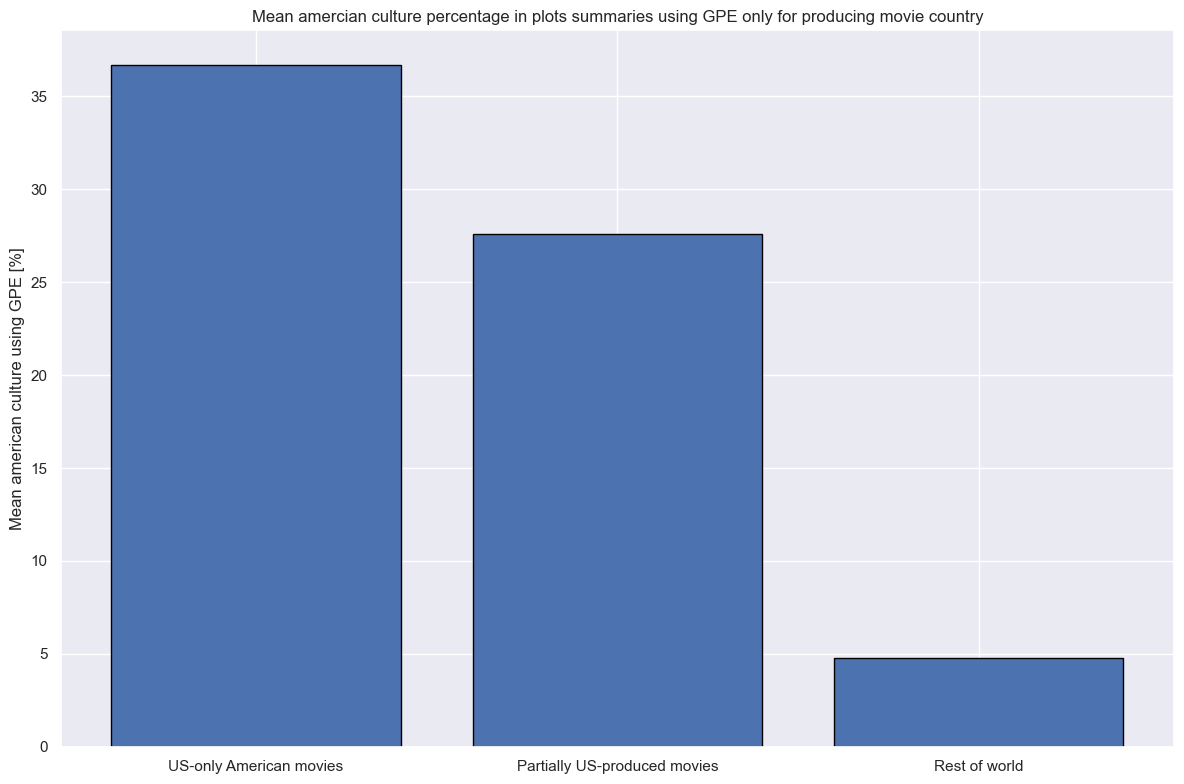

In [18]:
list_df_names = ['US-only produced movies', 'Partially US-produced movies' , 'Non-US produced movies (RoW)']
list_df_GPE_results = [df_GPE_us_only, df_GPE_partially_us, df_GPE_RoW]
mean_american_culture_GPE_results = []

for name, df in zip(list_df_names, list_df_GPE_results):
    mean_american_culture_GPE_results.append(df['Percentage_american_culture'].mean()*100)

plt.figure(figsize=(12,8))
plt.bar(list_df_names, mean_american_culture_GPE_results, edgecolor ='black', color = {'darkcyan', 'sandybrown', 'lightpink'})
plt.ylabel("Mean american culture using GPE [%]")
plt.title("Mean amercian culture percentage in plots summaries using GPE only for producing movie country")
plt.tight_layout()
# plt.savefig("data/plots_best/mean_american_culture_GPE.png", dpi = 300, bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(12,8))
sns.barplot(list_df_names, mean_american_culture_GPE_results, edgecolor ='black')
plt.ylabel("Mean american culture using GPE [%]")
plt.title("Mean amercian culture percentage in plots summaries using GPE only for producing movie country")
plt.tight_layout()
# plt.savefig("data/plots_best/mean_american_culture_GPE.png", dpi = 300, bbox_inches = 'tight')
plt.show()

The above barplot illustrates the mean percentage of American culture using location only (i.e. GPE) depending on the movie's country of production. First, one notices that US-only produced movies show the highest percentage of American culture with 36.7 %. This means that movies produced in the US tends **on average** to tell a story that takes place at least partially in the US. Indeed, during the creation of this American percentage culture, the NLP pipeline implemented considers all locations present in the plot summary's text. Next, the partially US-produced show  **on average** a percentage of american culture of about 27 %, correponding to a 9 % decrease compared to US-only produced movies. One thus observes that films not strictly produced in the US tends to less put into spotlight the American culture (**voir si je m'emballe pas trop**). Finally, movies produced outside of the US show **on average** 4.8 % of american culture, a 22.2 % decrease compared to partially US-produced movies. Once again, movies produced outside of the US tends to tells stories that are nearly not happening in the US.

Finally, one must look at these results with a critical eye (**vois si ok formualtion**). First, many movies in the dataset do not contain any GPE because they are pure fictions (des oeuvres de pure finction). For example, *Star Wars*, *The Lord of the Rings* **ou encore** *Alice's wonderland* (**check**) contains only fictitious locations that the NLP pipeline does not (and must) recognize. This tends to lower the mean percenatge of american culture calculated. Indeed, one recalls that the mean is sensitive to outliers and to over-represented values. Then movies where their plot is **à cheval** between real and fictitious locations are taken into account as targeted. The last limitation of this approach originates from the *Geopy* library itself. Indeed, some locations like Palestine are recognized as being more likely to be in the US than in Midle East. Thus, the *Nominatim* function of *Geopy* allow to produce robut results even though they are note perfect.

**changer couleur pour avoir le mêm code couleur + implémenter en seaborn pour avoir les errors bars et les interpréter**

## Assessing the american culture in plots summaries using the crafted amercian words lexicon
The goal is here to scan once again the plot summaries of US-only, partially US- and Non-US produced movies but this time with a **handcrafted lexicon representing a realistic and robust sample of the american culture**. For more details about how this lexicon was created, please look at the notebook called *American_vocab.ipynb* (**pas oublier de modifer le nom au cas où on change le nom du notebook**).

Once again, each of the 3 "sub"-dataframes are processed separately due to the consequent running time due to the use of the `en_core_web_trf` spacy NLP model (see below).

Load the set of american words representing the lexicon created from Wikipedia data (see notebook *american_vocab.ipynb*) for more details

In [10]:
with open('data/NLP_datasets/NLP_US_lexicon/unique_us_words_set.pkl', 'rb') as f:
    unique_us_words_set = pickle.load(f)

print(f"The lexicon of American words contains {len(unique_us_words_set)} words.")
print(f"The first 15 words of the lexicon are:\n {list(unique_us_words_set)[:15]}") # transform the us lexicon into a list to allow for indexing operation

The lexicon of American words contains 200 words.
The first 15 words of the lexicon are:
 ['college football', 'turkey', 'front porch', 'lifeguard', 'backyard', 'election', 'pledge', 'drive in', 'college life', 'statue of liberty', 'mall', 'rust belt', 'democracy', 'nascar', 'grill']


Creating the function that will process all the data along with the lexicon

In [11]:
def compute_US_lexicon_frequencies_batch(summaries, us_lexicon):
    """
    Function that implement batch processing of plot summaries and extract typical american words frequencies using a pre-defined lexicon of typical american words. 
    If available on the machine running the notebook, CUDA is enabled for faster processing.
    params: texts called 'summaries' and a set of US words containing the typical american words
    returns: all the token entities and all the US token frequencies detected in the summary as a list
    """

    # Verify if laptop running the script has a GPU and CUDA enabled
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        spacy.require_gpu() # enable GPU use for Spacy, taken from: https://stackoverflow.com/questions/75355264/how-to-enable-cuda-gpu-acceleration-for-spacy-on-windows 
        nlp = spacy.load("en_core_web_trf") # uses a more complex model leveraging transformers
        print("Using Spacy English transformer pipeline.")
    else:
        print("CUDA is NOT available. Using CPU.")
        nlp = spacy.load("en_core_web_sm")
        print("Using Spacy English pipeline optimized for CPU.")

    # Create PhraseMatcher for multi-word expressions
    matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
    patterns = [nlp.make_doc(phrase) for phrase in us_lexicon]
    matcher.add("US_Culture", patterns)

    results = []
    for doc in tqdm(nlp.pipe(summaries, batch_size=500), total=len(summaries), desc="Processing Summaries"):
        # Tokenize and filter tokens
        summary_tokens = [
            token.lemma_.lower() for token in doc
            if not token.is_stop and token.is_alpha
        ]

        # Count total token frequencies
        Tokens_frequencies_all = Counter(summary_tokens)

        # Find matches for US lexicon terms
        matches = matcher(doc)
        matched_terms = [doc[start:end].text.lower() for _, start, end in matches]

        # Count US lexicon term frequencies
        Tokens_US_frequencies = Counter(matched_terms)

        # Calculate percentage of US culture terms
        total_tokens = sum(Tokens_frequencies_all.values())
        Percentage_US_culture_lexicon = (
            sum(Tokens_US_frequencies.values()) / total_tokens if total_tokens > 0 else 0
        )

        results.append((total_tokens, Tokens_US_frequencies, Percentage_US_culture_lexicon))
    
    return results

**Disclaimer**: one must keep in mind that **the three below cells run** in about $\color{red}{\text{ minutes, 2 hours and 23 minutes, 2 hours 40 minutes}}$ with the **Nvidia GeForce RTX 3050 Ti Laptop GPU** used here.

#### 1) Processing the partially US-produced movies

In [ ]:
df_plots_us_partially_movies_US_lexicon = plot_summaries_us_partially_movies.copy()

# Monitor the running time of this cell
start_time = time.time()
print("Processing starting.")

extracted_results = compute_US_lexicon_frequencies_batch(df_plots_us_partially_movies_US_lexicon['Summary'].tolist(), unique_us_words_set)
df_plots_us_partially_movies_US_lexicon['Total_tokens'] = [res[0] for res in extracted_results]
df_plots_us_partially_movies_US_lexicon['Tokens_US_frequencies'] = [res[1] for res in extracted_results]
df_plots_us_partially_movies_US_lexicon['Percentage_american_culture_lexicon'] = [res[2] for res in extracted_results]

df_us_partially_movies_NLP_lexicon = df_plots_us_partially_movies_US_lexicon.drop(columns=['Summary']) # keeping all the info of the original df, the new GPE columns and dropping the summaries for more clarity and later use

df_us_partially_movies_NLP_lexicon.to_csv("data/NLP_datasets/NLP_US_lexicon/us_partially_movies_NLP_US_lexicon.csv", sep=',', encoding='utf-8', index=False, header = True)# hard code the encoding to avoid anay problems as seen in the lecture

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

Quick visualization of the results for the partially US-produced movies

In [ ]:
df_US_lexicon_us_partially = pd.read_csv("data/NLP_datasets/NLP_US_lexicon/us_partially_movies_NLP_US_lexicon.csv", sep=',') 

# Percentages of american culture using GPE
mean_american_culture_US_lexicon_us_partially_movies = df_US_lexicon_us_partially ['Percentage_american_culture_lexicon'].mean()*100

# count the proportions of zeros
df_US_lexicon_us_partially['Percentage_american_culture_lexicon'] = pd.to_numeric(df_US_lexicon_us_partially['Percentage_american_culture_lexicon']).astype('float64')
proportion_0_percentage_us_partially_US_lexicon = (len(df_US_lexicon_us_partially [df_US_lexicon_us_partially['Percentage_american_culture_lexicon'] == 0.0])/len(df_US_lexicon_us_partially )*100)

print(f"The mean american culture percentage for Non-US produced movies using only GPE information is {mean_american_culture_US_lexicon_us_partially_movies:.2f} %.")
print(f"The percentage of zero values on the Non US-produced GPE dataset is: {proportion_0_percentage_us_partially_US_lexicon:.2f} %.")

df_US_lexicon_us_partially.head(10)

#### 2) Processing the US-only produced movies

In [13]:
df_plots_us_only_movies_US_lexicon = plot_summaries_us_movies.copy()

# Monitor the running time of this cell
start_time = time.time()
print("Processing starting.")

extracted_results = compute_US_lexicon_frequencies_batch(df_plots_us_only_movies_US_lexicon['Summary'].tolist(), unique_us_words_set)
df_plots_us_only_movies_US_lexicon['Total_tokens']= [res[0] for res in extracted_results]
df_plots_us_only_movies_US_lexicon['Tokens_US_frequencies'] = [res[1] for res in extracted_results]
df_plots_us_only_movies_US_lexicon['Percentage_american_culture_lexicon'] = [res[2] for res in extracted_results]

df_plots_us_only_movies_US_lexicon = df_plots_us_only_movies_US_lexicon.drop(columns=['Summary']) # keeping all the info of the original df, the new GPE columns and dropping the summaries for more clarity and later use

df_plots_us_only_movies_US_lexicon.to_csv("data/NLP_datasets/NLP_US_lexicon/us_only_movies_NLP_US_lexicon.csv", sep=',', encoding='utf-8', index=False, header = True)# hard code the encoding to avoid anay problems as seen in the lecture

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

Processing starting.
CUDA is available. Using GPU.
Using Spacy English transformer pipeline.


Processing Summaries: 100%|██████████| 17776/17776 [2:23:50<00:00,  2.06it/s]  


Execution time: 143.92 minutes. NLP processing done.


Quick visualization of the results for the US-only produced movies

In [15]:
df_US_lexicon_us_only = pd.read_csv("data/NLP_datasets/NLP_US_lexicon/us_only_movies_NLP_US_lexicon.csv", sep=',') 

# Percentages of american culture using GPE
mean_american_culture_US_lexicon_us_only_movies = df_US_lexicon_us_only['Percentage_american_culture_lexicon'].mean()*100

# count the proportions of zeros
df_US_lexicon_us_only['Percentage_american_culture_lexicon'] = pd.to_numeric(df_US_lexicon_us_only['Percentage_american_culture_lexicon']).astype('float64')
proportion_0_percentage_us_only_US_lexicon = (len(df_US_lexicon_us_only[df_US_lexicon_us_only['Percentage_american_culture_lexicon'] == 0.0])/len(df_US_lexicon_us_only)*100)

print(f"The mean american culture percentage for Non-US produced movies using only GPE information is {mean_american_culture_US_lexicon_us_only_movies:.2f} %.")
print(f"The percentage of zero values on the Non US-produced GPE dataset is: {proportion_0_percentage_us_only_US_lexicon:.2f} %.")

df_US_lexicon_us_only.head(10)

The mean american culture percentage for Non-US produced movies using only GPE information is 0.59 %.
The percentage of zero values on the Non US-produced GPE dataset is: 63.84 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,Total_tokens,Tokens_US_frequencies,Percentage_american_culture_lexicon
0,The Hunger Games,686533290.0,"Action,Adventure,Sci-Fi",2012.0,7.2,1022897.0,410,Counter({'president': 2}),0.004878
1,The Lemon Drop Kid,2300000.0,"Comedy,Crime,Music",1951.0,7.0,2303.0,438,Counter(),0.000000
2,Dark Water,49483352.0,"Drama,Horror,Mystery",2005.0,5.6,66164.0,375,Counter(),0.000000
3,Sing,2260616.0,"Drama,Musical",1989.0,6.7,974.0,296,"Counter({'diner': 3, 'high school': 1})",0.013514
4,Meet John Doe,NaN,"Comedy,Drama,Romance",1941.0,7.6,15255.0,290,"Counter({'baseball': 1, 'diner': 1})",0.006897
5,Husband for Hire,NaN,NaN,2008.0,NaN,NaN,182,Counter(),0.000000
6,Exodus,NaN,NaN,1960.0,NaN,NaN,409,Counter(),0.000000
7,House Party 2,19438638.0,"Comedy,Drama,Music",1991.0,5.3,7205.0,683,Counter({'campus': 5}),0.007321
8,Charlie Chan's Secret,NaN,NaN,1936.0,NaN,NaN,56,Counter(),0.000000
9,The Biggest Fan,NaN,NaN,2002.0,NaN,NaN,88,"Counter({'high school': 2, 'prom': 1})",0.034091


#### 3) Processing the Non US-produced movies (RoW)

In [12]:
df_plots_RoW_movies_US_lexicon = plot_summaries_RoW_movies.copy()

# Monitor the running time of this cell
start_time = time.time()
print("Processing starting.")

extracted_results = compute_US_lexicon_frequencies_batch(df_plots_RoW_movies_US_lexicon['Summary'].tolist(), unique_us_words_set)
df_plots_RoW_movies_US_lexicon['Total_tokens'] = [res[0] for res in extracted_results]
df_plots_RoW_movies_US_lexicon['Tokens_US_frequencies'] = [res[1] for res in extracted_results]
df_plots_RoW_movies_US_lexicon['Percentage_american_culture_lexicon'] = [res[2] for res in extracted_results]

df_plots_RoW_movies_US_lexicon = df_plots_RoW_movies_US_lexicon.drop(columns=['Summary']) # keeping all the info of the original df, the new GPE columns and dropping the summaries for more clarity and later use

df_plots_RoW_movies_US_lexicon.to_csv("data/NLP_datasets/NLP_US_lexicon/RoW_movies_NLP_US_lexicon.csv", sep=',', encoding='utf-8', index=False, header = True)# hard code the encoding to avoid anay problems as seen in the lecture

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60:.2f} minutes. NLP processing done.")

Processing starting.
CUDA is available. Using GPU.
Using Spacy English transformer pipeline.


Processing Summaries: 100%|██████████| 18105/18105 [2:07:07<00:00,  2.37it/s]  


Execution time: 127.21 minutes. NLP processing done.


Quick visualization of the results for the Non-US produced movies

In [13]:
df_US_lexicon_RoW = pd.read_csv("data/NLP_datasets/NLP_US_lexicon/RoW_movies_NLP_US_lexicon.csv", sep=',') 

# Percentages of american culture using GPE
mean_american_culture_US_lexicon_RoW_movies = df_US_lexicon_RoW['Percentage_american_culture_lexicon'].mean()*100

# count the proportions of zeros
df_US_lexicon_RoW['Percentage_american_culture_lexicon'] = pd.to_numeric(df_US_lexicon_RoW['Percentage_american_culture_lexicon']).astype('float64')
proportion_0_percenatge_RoW_US_lexicon = (len(df_US_lexicon_RoW[df_US_lexicon_RoW['Percentage_american_culture_lexicon'] == 0.0])/len(df_US_lexicon_RoW)*100)

print(f"The mean american culture percentage for Non-US produced movies using only GPE information is {mean_american_culture_US_lexicon_RoW_movies:.2f} %.")
print(f"The percentage of zero values on the Non US-produced GPE dataset is: {proportion_0_percenatge_RoW_US_lexicon:.2f} %.")

df_US_lexicon_RoW.head(10)

The mean american culture percentage for Non-US produced movies using only GPE information is 0.25 %.
The percentage of zero values on the Non US-produced GPE dataset is: 82.79 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,Total_tokens,Tokens_US_frequencies,Percentage_american_culture_lexicon
0,Taxi Blues,NaN,NaN,1990.0,NaN,NaN,16,Counter(),0.000000
1,Narasimham,NaN,"Action,Drama",2000.0,7.6,2012.0,270,Counter({'supreme court': 1}),0.003704
2,Up and Down,2705163.0,NaN,2004.0,NaN,NaN,50,Counter(),0.000000
3,Ghost In The Noonday Sun,NaN,NaN,1973.0,NaN,NaN,32,Counter(),0.000000
4,Ashes to Ashes,NaN,Thriller,1999.0,7.1,23.0,217,Counter({'independence': 1}),0.004608
5,The Rats of Tobruk,NaN,"Action,Drama,War",1944.0,5.4,316.0,82,Counter(),0.000000
6,Nee Sneham,NaN,NaN,2002.0,NaN,NaN,212,Counter(),0.000000
7,Bhagwan Dada,NaN,NaN,1986.0,NaN,NaN,808,Counter({'pledge': 1}),0.001238
8,Mr. & Mrs. '55,NaN,"Comedy,Musical,Romance",1955.0,7.1,688.0,101,Counter({'freedom': 1}),0.009901
9,Amici miei,NaN,"Comedy,Drama",1975.0,7.9,8171.0,163,Counter(),0.000000


#### Visualization of the mean percentage of american culture using the US words lexicon

In [ ]:
list_df_names = ['US-only produced movies', 'Partially US-produced movies' , 'Non-US produced movies (RoW)']
list_df_US_lexicon_results = [df_US_lexicon_us_only, df_US_lexicon_us_partially, df_US_lexicon_RoW]
mean_american_culture_US_lexicon_results = []

for name, df in zip(list_df_names, list_df_US_lexicon_results):
    mean_american_culture_GPE_results.append(df['Percentage_american_culture'].mean()*100)

plt.figure(figsize=(12,8))
plt.bar(list_df_names, mean_american_culture_GPE_results, edgecolor ='black')
plt.ylabel("Mean american culture [%]")
plt.title("Mean amercian culture percentage in plots summaries using lexicon of US words for producing movie country")
plt.tight_layout()
# plt.savefig("data/plots_best/mean_american_culture_GPE.png", dpi = 300, bbox_inches = 'tight')
plt.show()

#### Comparison of the two NLP methods: GPE vs US lexicon

In [ ]:
# Dataframe summarizing the findings.

dict_NLP_american_culture = {'US-only produced movies': [mean_american_culture_GPE_results[0], mean_american_culture_US_lexicon_results[0]], 
                   'Partially US-produced movies': [mean_american_culture_GPE_results[1], mean_american_culture_US_lexicon_results[1]], 
                   'Non US-produced movies': [mean_american_culture_GPE_results[2], mean_american_culture_US_lexicon_results[2]] 
                   }

index_names = ["GPE", "US lexicon"]

df_summary_NLP_results = pd.DataFrame(dict_NLP_american_culture, index = index_names)